In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('C:/Users/askha/Downloads/london.csv', parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
# проверим есть ли пропущенные значения
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [7]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

Для начала попробуем посмотреть на число поездок по датам и времени. Построим график, где:

по оси x – дата (timestamp)
по оси y – число поездок (cnt)

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

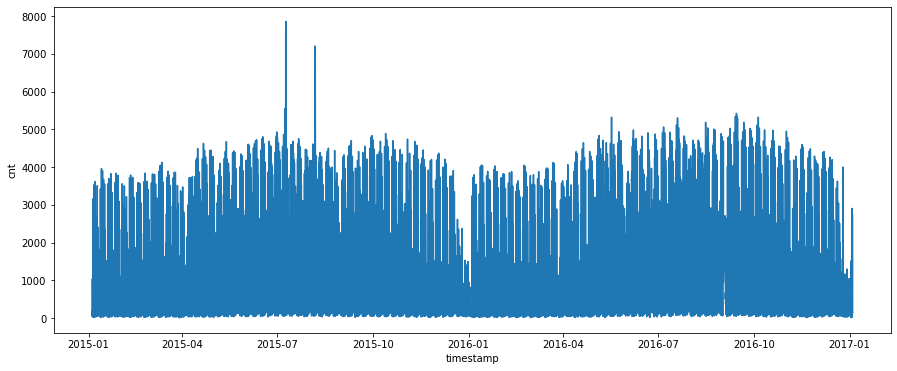

In [15]:
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(data=df, x="timestamp", y="cnt")

по графику выше сложно что-либо понять, поэтому нужно преобразовать данные, чтобы увидеть тренды.

In [23]:
# поставим timestamp в индекс предварительно отсортировав эту колонку 
df_sorted = df.sort_values('timestamp') \
    .set_index('timestamp')
df_sorted.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [48]:
# преобразуем данные по дням с помощью resample
df_sorted = df_sorted.resample(rule='D').sum().reset_index()

<AxesSubplot:>

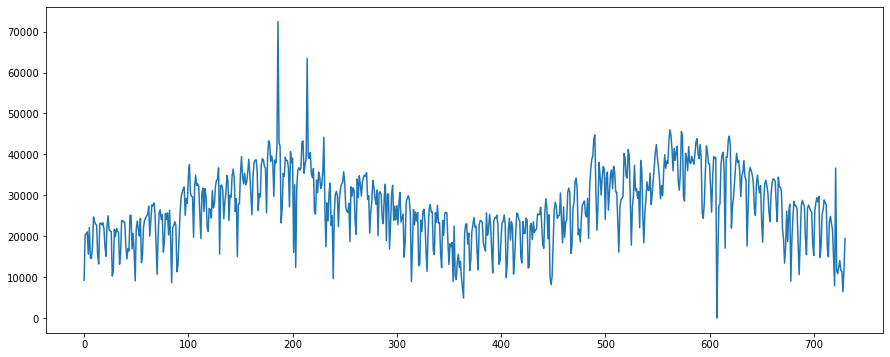

In [49]:
fig = plt.subplots(figsize=(15, 6))
df_sorted.cnt.plot()

In [ ]:
# по графику видно, что :
# Максимальное число аренд за день составляет более 70 000
# Зимой число аренд меньше, чем летом
# Встречаются как очень резкие скачки числа аренд, так и падения

In [ ]:
# Итак, мы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в тот день.
# Для этого разделим дальнейшие действия на несколько этапов:

# сначала посчитаем скользящее среднее, чтобы сгладить ряд
# далее – разницу между наблюдаемыми и сглаженными значениями
# определим верхние и нижние границы 99% доверительного интервала 
# найдем причины аномалий!


In [42]:
df_rolling = df_sorted.rolling(window=3) \
    .mean() \
    .reset_index()
df_rolling.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,16739.666667,147.000000,101.500000,2027.833333,258.833333,74.333333,0.0,8.0,72.0
3,2015-01-07,20683.000000,184.333333,130.833333,1872.500000,350.333333,71.333333,0.0,0.0,71.0
4,2015-01-08,19092.666667,198.000000,139.500000,1864.500000,443.333333,72.666667,0.0,0.0,71.0


Теперь посчитаем разницу между наблюдаемыми и подсчитанными значениями

In [55]:
result = df_sorted.cnt - df_rolling.cnt
std = np.std(result)
round(std, 2) #стандартное отклонение

4558.59

In [56]:
# определим верхние и нижние границы 99% доверительного интервала 
df_rolling['lower_bound'] = df_rolling.cnt - 2.576 * std
df_rolling['upper_bound'] = df_rolling.cnt + 2.576 * std
df_rolling

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,lower_bound,upper_bound
0,2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,16739.666667,147.000000,101.500000,2027.833333,258.833333,74.333333,0.0,8.0,72.0,4996.747479,28482.585854
3,2015-01-07,20683.000000,184.333333,130.833333,1872.500000,350.333333,71.333333,0.0,0.0,71.0,8940.080812,32425.919188
4,2015-01-08,19092.666667,198.000000,139.500000,1864.500000,443.333333,72.666667,0.0,0.0,71.0,7349.747479,30835.585854
...,...,...,...,...,...,...,...,...,...,...,...,...
726,2016-12-30,12682.000000,73.666667,28.166667,2287.166667,179.666667,67.000000,0.0,0.0,72.0,939.080812,24424.919188
727,2016-12-31,12347.333333,115.833333,68.333333,2237.000000,227.000000,76.000000,0.0,8.0,72.0,604.414146,24090.252521
728,2017-01-01,9803.666667,141.666667,84.333333,2224.666667,291.500000,117.666667,0.0,16.0,72.0,-1939.252521,21546.585854
729,2017-01-02,9889.333333,145.333333,83.333333,2100.333333,308.833333,92.333333,8.0,16.0,72.0,-1853.585854,21632.252521


In [61]:
# И наконец – изучим аномально высокие значения! 
# выведем наблюдения, для которых наблюдаемые
# значения оказались больше верхней границы 99% доверительного интервала.

df_sorted['lower_bound'] = df_rolling.lower_bound
df_sorted['upper_bound'] = df_rolling.upper_bound
df_sorted.query('cnt > upper_bound')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,lower_bound,upper_bound
186,2015-07-09,72504,427.0,421.0,1175.5,311.5,28.0,0.0,0.0,24.0,38962.080812,62447.919188
214,2015-08-06,63468,466.5,466.5,1625.0,357.5,50.0,0.0,0.0,24.0,34884.414146,58370.252521
609,2016-09-04,27512,452.5,452.5,1676.5,561.5,71.0,0.0,24.0,48.0,2516.080812,26001.919188
721,2016-12-25,36653,300.0,300.0,1906.0,664.0,87.0,0.0,24.0,72.0,7907.747479,31393.585854


больше всего поездок было 2015-07-09. В этот день были забастовки в лондонском метро.


In [66]:
# Проделаем аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого.
df_sorted.query('cnt < lower_bound') \
    .sort_values('cnt')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,lower_bound,upper_bound
607,2016-09-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14343.414146,37829.252521
314,2015-11-14,8898,270.0,235.0,1951.0,560.0,105.0,0.0,24.0,48.0,9294.414146,32780.252521
678,2016-11-12,8990,214.0,180.0,1976.0,247.5,108.0,0.0,23.0,46.0,9135.080812,32620.919188
130,2015-05-14,15609,237.5,189.5,2039.0,513.0,118.0,0.0,0.0,0.0,16966.414146,40452.252521
201,2015-07-24,16034,380.5,380.5,1810.0,275.0,108.0,0.0,0.0,24.0,19270.747479,42756.585854
615,2016-09-10,17080,460.0,460.0,1932.0,392.0,89.0,0.0,24.0,48.0,19519.080812,43004.919188
232,2015-08-24,17400,380.0,380.0,2099.0,321.0,126.0,0.0,0.0,24.0,17786.414146,41272.252521
621,2016-09-16,21967,416.0,416.0,1900.5,416.0,115.0,0.0,0.0,48.0,24450.414146,47936.252521
189,2015-07-12,23240,444.5,444.5,1811.5,520.5,80.0,0.0,24.0,24.0,24293.747479,47779.585854


In [67]:
# здесь вероятнее всего возникла ошибка при сборе данных.